In [66]:
%matplotlib notebook

In [52]:
from lib import filedb
import pandas as pd
import os.path
import numpy as np
from lib import strainmap
#from figures.figure_63x_sigb_histo import subfig_indivfile_histo
from lib.analysis.sigb_histograms import make_indivfile_histogram
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [50]:
from lib.figure_util import strain_color
from lib import figure_util

In [7]:
basedir = "../../datasets/LSM700_63x_sigb"

cell_df = pd.read_hdf(os.path.join(basedir, "single_cell_data.h5"), "cells")
file_df = filedb.get_filedb(os.path.join(basedir, "file_list.tsv"))

In [15]:
strain_map, des_strain_map = strainmap.load()

In [8]:
for c in cell_df.columns:
    print(c)

area
distance
eccentricity
global_file_id
green_raw_bg_autofluor_bleedthrough_maxnorm
green_raw_bg_autofluor_bleedthrough_mean
green_raw_bg_autofluor_bleedthrough_meannorm
green_raw_bg_autofluor_bleedthrough_std
green_raw_bg_autofluor_maxnorm
green_raw_bg_autofluor_mean
green_raw_bg_autofluor_meannorm
green_raw_bg_autofluor_std
green_raw_bg_maxnorm
green_raw_bg_mean
green_raw_bg_meannorm
green_raw_bg_std
green_raw_maxnorm
green_raw_mean
green_raw_meannorm
green_raw_std
image_col
image_row
length
perimeter
red_raw_bg_autofluor_maxnorm
red_raw_bg_autofluor_mean
red_raw_bg_autofluor_meannorm
red_raw_bg_autofluor_std
red_raw_bg_maxnorm
red_raw_bg_mean
red_raw_bg_meannorm
red_raw_bg_std
red_raw_maxnorm
red_raw_mean
red_raw_meannorm
red_raw_std
segment_label
slice_col
slice_row


In [250]:
gchan = "green_raw_bg_maxnorm"
rchan = "red_raw_bg_maxnorm"
rchan = "red_raw_bg_meannorm"
gchan = "green_raw_bg_meannorm"
# gchan = "green_raw_bg_mean"
# rchan = "red_raw_bg_mean"
    # rchan = "meannorm_red"
    #gchan = "green_autobgbleed_maxnorm"
    #gchan = "green_autobg_maxnorm"
    #rchan = "red_autobg_maxnorm"


In [151]:
cell_df = cell_df[cell_df[rchan] > 0].copy()

In [263]:
max_val = 30000#4#2.5 
gmax_val = 10000#6#4
max_val = 6.5 #2.5 
gmax_val = 6.6#4
nbins = 150
rbins = (0, max_val, nbins)
gbins = (0, gmax_val, nbins)
percentile = 0
slice_srt, slice_end = 5,7# 6 #10, 15
slice_info = (slice_srt, slice_end)
time = 48
location = "center"
dset = time, location, strain
figure_dir = "../../figures/figure_63x_sigb_histo/"


In [153]:
list_of_histos = [ 
        ("wt_sigar_sigby", rchan,   "WT P$_{sigA}$-RFP", ""),
        ("wt_sigar_sigby", gchan, "WT P$_{sigB}$-YFP", ""),
        ("delqp_sigar_sigby", gchan, "ΔrsbQP P$_{sigB}$-YFP", ""),
        ("delru_sigar_sigby", gchan, "ΔrsbRU P$_{sigB}$-YFP", "")
]

In [45]:
def make_cached_data(df, column, inbins, slice_info, dset, percentile, basedir="."):
    bins = np.linspace(*inbins)
    histo_res = make_indivfile_histogram(df,
                                         column,
                                         bins,
                                         slice_info,
                                         percentages=True,
                                         percentile=percentile,
                                         print_out_stats=True)
    names = "cbins", "indiv_hists", "mean_indiv", "histo_all", "uniques", "n", "stats"
    save = { k: v for (k, v) in zip(names, histo_res)} 
    datadir = os.path.join(basedir, "data")
    try: 
        os.mkdir(datadir)
    except FileExistsError as e:
        pass
    path = os.path.join(datadir, "{column}_{inbins}_{slice_info}_{percentile}_{dset}.mat".format(**locals()))
    scipy.io.savemat(path, save)
    return save

In [46]:
def get_cached_data(column, inbins, slice_info, dset, percentile, basedir="."):
    path = os.path.join(basedir, "data/{column}_{inbins}_{slice_info}_{percentile}_{dset}.mat".format(**locals()))
    save = scipy.io.loadmat(path)
    return save

In [266]:

for i, (strain, chan, label, color) in enumerate(list_of_histos):
    print(label)
    
    fids = file_df[(file_df["time"] == time) &
                    (file_df["location"] == location) &
                    (file_df["strain"] == des_strain_map[strain])].index
    strain_df = cell_df[cell_df["global_file_id"].isin(fids)]
    
    tbins = gbins
    if "red" in chan:
        tbins = rbins
    dset = time, location, strain
    make_cached_data(strain_df, chan, tbins, slice_info,  dset, percentile, figure_dir)




WT P$_{sigA}$-RFP
mean: 1.19
std: 0.42
CV: 2.81
Moment skew: 0.12
Pearson mode skew: -0.07
Number of files: 24
Cells: 4231
------------------------
WT P$_{sigB}$-YFP
mean: 1.96
std: 0.93
CV: 2.11
Moment skew: 0.79
Pearson mode skew: -0.13
Number of files: 24
Cells: 4231
------------------------
ΔrsbQP P$_{sigB}$-YFP
mean: 1.51
std: 0.67
CV: 2.27
Moment skew: 0.47
Pearson mode skew: 0.28
Number of files: 16
Cells: 2481
------------------------
ΔrsbRU P$_{sigB}$-YFP
mean: 2.61
std: 1.16
CV: 2.24
Moment skew: 0.58
Pearson mode skew: 0.30
Number of files: 18
Cells: 3268
------------------------


In [48]:
def get_figure(ax, df, column, inbins, slice_info, dset, percentile, basepath, kwargs={},):

    cdata = get_cached_data(column, inbins, slice_info, dset, percentile, basepath)
    (meanval, std, mskewval, pskewval, modeval, cvval) = cdata["stats"].flatten()
    cbins = cdata["cbins"].flatten()
    indiv_hists = cdata["indiv_hists"]
    histo_all = cdata["histo_all"].flatten()

    if "max_min" not in kwargs:
        kwargs["max_min"] = "indiv"

    if kwargs["max_min"] == "color":
        min_extents = np.min(indiv_hists, axis=0)
        max_extents = np.max(indiv_hists, axis=0)
        ax.fill_between(cbins, max_extents, min_extents, color=kwargs["color"], alpha=0.3)
    elif kwargs["max_min"] == "indiv":
        for i in range(indiv_hists.shape[0]):
            ax.plot(cbins, indiv_hists[i, :], color="gray", alpha=0.3)
    else:
        pass

    if "mode_mean" in kwargs and kwargs["mode_mean"] is False:
        model, meanl = None, None
    else:
        model = ax.axvline(modeval, color=figure_util.mode_color, label="Mode", linewidth=1.0, linestyle=":") 
        meanl =  ax.axvline(meanval, color=figure_util.mean_color, label="Mean", linewidth=1.0, linestyle="-.") 
    line, = ax.plot(cbins, histo_all, color=kwargs["color"])
    ax.locator_params(axis='x', nbins=4)
    #ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, steps=[0, 3, 6, 9]))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, integer=True))
    return ax, line, (model, meanl)

In [127]:
import scipy.stats 

In [234]:
def get_figure_std(ax, column, inbins, slice_info, dset, percentile, basepath, kwargs={},):

    cdata = get_cached_data(column, inbins, slice_info, dset, percentile, basepath)
    (meanval, std, mskewval, pskewval, modeval, cvval) = cdata["stats"].flatten()
    cbins = cdata["cbins"].flatten()
    indiv_hists = cdata["indiv_hists"]
    histo_all = cdata["histo_all"].flatten()
    print(indiv_hists.shape)

    if "max_min" not in kwargs:
        kwargs["max_min"] = "indiv"
    
    model, meanl = None, None
    if "mode_mean" in kwargs and kwargs["mode_mean"] is True:
        model = ax.axvline(modeval, color=figure_util.mode_color, label="Mode", linewidth=1.0, linestyle=":") 
        meanl = ax.axvline(meanval, color=figure_util.mean_color, label="Mean", linewidth=1.0, linestyle="-.") 

    if kwargs["max_min"] == "color":
#         min_extents = np.min(indiv_hists, axis=0)
#         max_extents = np.max(indiv_hists, axis=0)
#         ax.fill_between(cbins, max_extents, min_extents, color=kwargs["color"], alpha=0.3)
#         min_stdiv = histo_all - (np.std(indiv_hists, axis=0)/np.sqrt(indiv_hists.shape[0]))
#         max_stdiv = histo_all + (np.std(indiv_hists, axis=0)/np.sqrt(indiv_hists.shape[0]))
        min_stdiv = histo_all - np.std(indiv_hists, axis=0)
        max_stdiv = histo_all + np.std(indiv_hists, axis=0)
        ax.fill_between(cbins, min_stdiv, max_stdiv, color=kwargs["color"], alpha=0.3)

    elif kwargs["max_min"] == "indiv":
        for i in range(indiv_hists.shape[0]):
            ax.plot(cbins, indiv_hists[i, :], color="gray", alpha=0.3)
    else:
        pass

    line, = ax.plot(cbins, histo_all, color=kwargs["color"])
    #line, = ax.plot(cbins, np.mean(indiv_hists, axis=0), color="red")

    print(cdata["stats"])
#     gx = np.linspace(0, 1, len(cbins))
#     gmean = cdata["stats"][0][0]/cbins[-1]
#     gstd = cdata["stats"][0][1]/cbins[-1]
#     gpdf = scipy.stats.norm.pdf(gx, loc=gmean, scale=gstd)
#     gaus, = ax.plot(cbins, gpdf )
    #print(np.trapz(scipy.stats.norm.pdf(cbins,loc=cdata["stats"][0][0], scale=cdata["stats"][0][1]), x=cbins))

    ax.locator_params(axis='x', nbins=4)
    #ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, steps=[0, 3, 6, 9]))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, integer=True))
    return ax, line, (model, meanl)

<IPython.core.display.Javascript object>


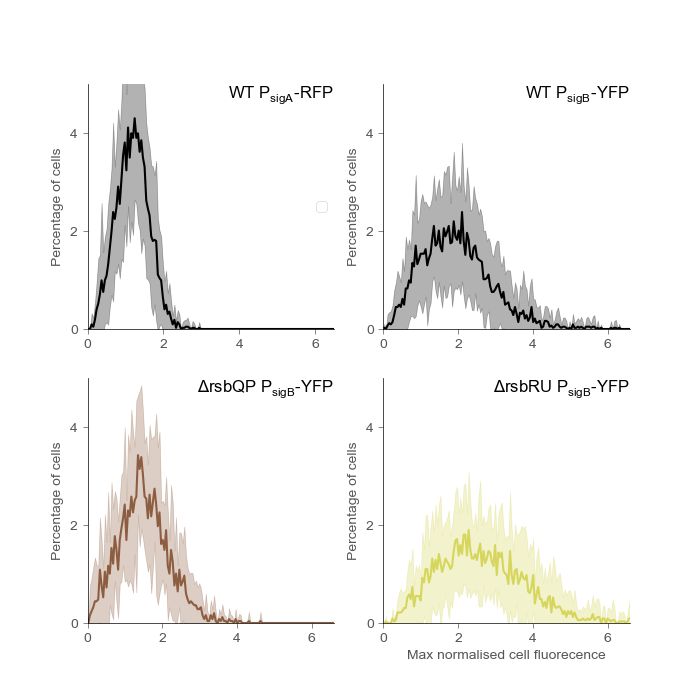

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(24, 149)
[[ 1.19078205  0.42316102  0.1193273  -0.07253612  1.22147651  2.81401641]]
(24, 149)
[[ 1.9575323   0.9283101   0.79360214 -0.13394974  2.08187919  2.10870516]]
(16, 149)
[[ 1.51330874  0.66774347  0.47436621  0.27622836  1.32885906  2.26630258]]
(18, 149)
[[ 2.60794343  1.16328011  0.57550405  0.29991317  2.2590604   2.24188776]]


In [265]:
fig, ax = plt.subplots( 2, 2)
fig.set_size_inches(7,7)

axhisto = ax.flatten() 


list_of_histos = [ 
        ("wt_sigar_sigby", rchan,   "WT P$_{sigA}$-RFP", strain_color["JLB021"]),
        ("wt_sigar_sigby", gchan, "WT P$_{sigB}$-YFP", strain_color["JLB021"]),
        ("delqp_sigar_sigby", gchan, "ΔrsbQP P$_{sigB}$-YFP", strain_color["JLB039"]),
        ("delru_sigar_sigby", gchan, "ΔrsbRU P$_{sigB}$-YFP", strain_color["JLB088"])
]

for i, (strain, chan, label, color) in enumerate(list_of_histos):

    dset = time, location, strain
    plot_args = {"color": color, "max_min":"color","mode_mean":False}
    tbins = gbins
    if "red" in chan:
        tbins = rbins
    axhisto[i], _, meandmed = get_figure_std(axhisto[i], 
                                         chan,
                                         tbins, 
                                         (slice_srt, slice_end), 
                                         dset,
                                         percentile,
                                         figure_dir,
                                         plot_args)
    
    axhisto[i].text(1.0, 1.0, label, 
                    horizontalalignment='right', 
                    verticalalignment='top',
                    color="black", 
                    fontsize=plt.rcParams["axes.titlesize"],
                    transform=axhisto[i].transAxes) 

#     axhisto[i].text(hisletter_lab[0], hisletter_lab[1], letters[i],
#                      transform=axhisto[i].transAxes, **letter_settings)

    leg = axhisto[0].legend(loc="center right")
        
    axhisto[-1].set_xlabel("Max normalised cell fluorecence")
 
    for a in np.ravel(axhisto):
        a.set_ylabel("Percentage of cells")
        a.set_ylim(0,5)
        a.set_xlim(0, gmax_val)
        #a.set_xlim(0, 5)
        a.tick_params(axis='x', which='both', direction='out')#, length=2, pad=0)
        a.tick_params(axis='y', which='both', direction='out')#, length=2, pad=0)

        
    axhisto[0].set_xlim(0, max_val)


## What does it look like with bleed through subtracted